# COMP47590: Advanced Machine Learning
# Assignment 1: Multi-label Classification

Name(s): Yili Lai, Qimeng Gan

Student Number(s): 15205910, 15205903

## Import Packages Etc

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import hamming_loss, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from imblearn.under_sampling import RandomUnderSampler

# import other useful packages

E:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Task 0: Load the Yeast Dataset

In [2]:
dataset = pd.read_csv('yeast.csv')
data = np.array(dataset.iloc[:,:103])
functions = np.array(dataset.iloc[:,103:])

Explore the dataset

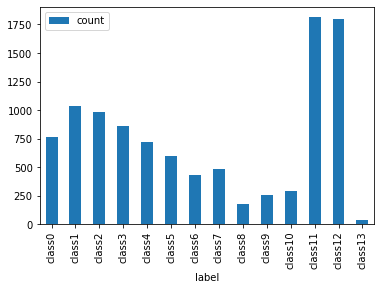

In [3]:
# visualize the number of the label
tag_dict ={}
num_classes = 14
for i in range(num_classes):
  tag_dict['class'+ i.__str__()] = dataset.iloc[:,103+i].value_counts()[1]
labelcount = pd.DataFrame(list(tag_dict.items()),columns=['label', 'count'])
labelcount.plot(x='label', y='count', kind='bar')
plt.show()

## Task 1: Implement the Binary Relevance Algorithm

In [4]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class BinaryRelevanceClassifier(BaseEstimator, ClassifierMixin):
    # Constructor for the classifier object
    def __init__(self, add_noise = False):
        self.add_noise = add_noise
        
    # The fit function to train a classifier
    def fit(self, data, functions):    
        # Create a new empty dictionary into which we will store relevance
        self.relevances_ = dict()

        # Iterate all functioins
        for i in range(14):
            status = functions[:,i]
            status = status.T
            self.relevances_[i] = BaggingClassifier(n_estimators=10, random_state=0).fit(data, status)
        
        # Return the classifier
        return self
            
    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['relevances_'])

        # Initialise an empty list to store the predictions made
        pos_functions = list()
        
        # Iterate all functioins to predict
        for i in range(14):
            pos_functions.append(self.relevances_[i].predict(X))
            
        return np.array(pos_functions).T

## Task 2: Implement the Binary Relevance Algorithm with Under-Sampling

In [5]:
class BRUnderSample(BaseEstimator, ClassifierMixin):
    # Constructor for the classifier object
    def __init__(self, under_sampling='undersampling'):
        self.under_sampling = under_sampling
        
    # The fit function to train a classifier
    def fit(self, data, functions):
         # Create a new empty dictionary into which we will store relevance
        self.relevances_ = dict()
        
        # Add an option to under-sample
        rus = RandomUnderSampler(random_state=0)
        
        # Iterate all functioins
        for i in range(14):
            status = functions[:,i]
            status = status.T

            # Under-sample data and status
            if self.under_sampling == 'undersampling':
                temp_data, status = rus.fit_sample(data,status)
                
            self.relevances_[i] = BaggingClassifier(n_estimators=10, random_state=0).fit(temp_data, status)

        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['relevances_'])
        
        # Initialise an empty list to store the predictions made
        pos_functions = list()

        # Iterate all functioins to predict
        for  i in range(14):
            pos_functions.append(self.relevances_[i].predict(X))
            
        return np.array(pos_functions).T

## Task 3: Compare the Performance of Different Binary Relevance Approaches

Split the data into a training and a test set

In [6]:
data_train, data_test, function_train, function_test = train_test_split(data, functions, random_state=0, train_size = 0.7)

E:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Train and evaluate 2 models

In [7]:
# Train Binary Relevance Model
br = BinaryRelevanceClassifier()
br.fit(data_train, function_train)
function_pred = br.predict(data_test)

# The fraction of labels that are incorrectly predicted
brLoss = hamming_loss(function_test, function_pred)
# F1 score: weighted average of the precision and recall
brfScore = f1_score(function_test, function_pred, average='macro')

In [8]:
bru = BRUnderSample()
bru.fit(data_train, function_train)
function_pred = bru.predict(data_test)

# The fraction of labels that are incorrectly predicted
bruLoss = hamming_loss(function_test, function_pred)
# F1 score: weighted average of the precision and recall
brufScore = f1_score(function_test, function_pred, average='macro')

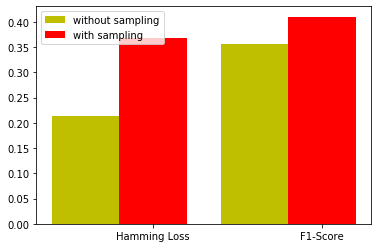

In [9]:
name_list = ['Hamming Loss','F1-Score']
num_list = [brLoss,brfScore]
num_list1 = [bruLoss,brufScore]
x = list(range(len(num_list)))
total,n = 0.8, 2
width = total / n

plt.bar(x, num_list, width = width, label ='without sampling',fc = 'y')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, num_list1, width = width, label ='with sampling',tick_label = name_list,fc = 'r')
plt.legend()
plt.show()

## Task 4: Implement the Classifier Chains Algorithm

In [10]:
# Write your code here
class ClassChainsClassifier(BaseEstimator, ClassifierMixin):
    # Constructor for the classifier object
    def __init__(self, add_noise = False):
        self.add_noise = add_noise
        
    # The fit function to train a classifier
    def fit(self, data, functions):
        data = data[:,:103]
        # Create a new empty dictionary into which we will store relevance
        self.relevances_ = dict()

        # Iterate all functioins
        for i in range(14):
            status = functions[:,i]
            status = status.T
            self.relevances_[i] = BaggingClassifier(n_estimators=10, random_state=0).fit(data, status)
            data = np.c_[data,status]
            
    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['relevances_'])

        # Initialise an empty list to store the predictions made
        pos_functions = list()
        
        print 
        # Iterate all functioins to predict
        for i in range(14):
            j = 103+i
            pos_functions.append(self.relevances_[i].predict(X[:,:j]))
            
        return np.array(pos_functions).T

## Task 5: Evaluate the Performance of the Classifier Chains Algorithm

In [11]:
# Write your code here


## Task 6: Reflect on the Performance of the Different Models Evaluated

*Write your reflection here (max 300 words)*